In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopy.distance
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans


/Users/harjitgakhal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### The objective of this project is to utlise the Google maps API to retrieve the distances between a common station providing easy to access to all parts of London(Stratford), and assess different aras within East London to discover the best places to live depending on your needs and your lifestyle. Below we load up the data for 3 differnet postcodes within the East London regions and merge these into a single dataframe.

##### The postcode data was retrieved from https://www.doogal.co.uk/UKPostcodes?Search=E and https://www.doogal.co.uk/UKPostcodes?Search=RM
##### The crime rate data was taken from http://www.plumplot.co.uk/East-London-crime-stats.html
##### The house price data was taken from https://www.plumplot.co.uk/London-house-prices.html


In [2]:
df_IG= pd.read_csv('IG postcodes.csv' )
df_RM = pd.read_csv('RM postcodes.csv')
df_e = pd.read_csv("E postcodes.csv")

df = pd.concat([df_e, df_IG, df_RM]).reset_index()
df = df.drop('index', axis=1)
df.head()

Postcode In Use?   Latitude  Longitude  Easting  Northing  Grid Ref  \
0   E1 0AA     Yes  51.512497  -0.052098   535267    181084  TQ352810   
1   E1 0AD     Yes  51.512910  -0.055323   535042    181124  TQ350811   
2   E1 0AE     Yes  51.510671  -0.052594   535238    180880  TQ352808   
3   E1 0AF     Yes  51.510864  -0.051161   535337    180904  TQ353809   
4   E1 0AG     Yes  51.513392  -0.054034   535130    181180  TQ351811   

           County       District      Ward  ...         Police force  \
0  Greater London  Tower Hamlets  Shadwell  ...  Metropolitan Police   
1  Greater London  Tower Hamlets  Shadwell  ...  Metropolitan Police   
2  Greater London  Tower Hamlets  Shadwell  ...  Metropolitan Police   
3  Greater London  Tower Hamlets  Shadwell  ...  Metropolitan Police   
4  Greater London  Tower Hamlets  Shadwell  ...  Metropolitan Police   

  Water company    Plus Code Average Income Sewage Company  \
0  Thames Water  9C3XGW6X+X5          43200            NaN   
1  Thames Water  9C3XGW7V+5V          43200            NaN   
2  Thames Water  9C3XGW6W+7X          62600            NaN   
3  Thames Water  9C3XGW6X+8G          43200            NaN   
4  Thames Water  9C3XGW7W+99          43200            NaN   

  Travel To Work Area          ITL level 2    ITL level 3  \
0              London  Inner London - East  Tower Hamlets   
1              London  Inner London - East  Tower Hamlets   
2              London  Inner London - East  Tower Hamlets   
3              London  Inner London - East  Tower Hamlets   
4              London  Inner London - East  Tower Hamlets   

                                               UPRNs  Distance to sea  
0  6027801,6027802,6029659,6029660,6029661,602966...          32.6997  
1  6155749,6155753,6158505,6195654,6195655,619565...          32.9273  
2  6024508,6024509,6024510,6024511,6024512,602451...          32.6950  
3  6024544,6024545,6024546,6024547,6024548,602454...          32.6017  
4  6356292,6356293,6356294,6356295,6356296,635629...          32.8502  

[5 rows x 53 columns]

In [84]:
df.shape # We can see that we have 32834 rows 

(32834, 53)

In [3]:
df['In Use?'].value_counts() # all postcodes are active so we can now proceed

In Use?
Yes    32834
Name: count, dtype: int64

## Investigating Train stations

In [4]:
df['Nearest station'].value_counts()


Nearest station
Romford            1395
Harold Wood         972
Chadwell Heath      850
Grays               812
Ilford              646
                   ... 
Brentwood             2
Bermondsey            1
Stone Crossing        1
Erith                 1
South Tottenham       1
Name: count, Length: 145, dtype: int64

#### We have 145 unique stations to represent 32000 people which may be reflective of transit time but not car and walk time

## Investigating Grid references

#### We have 32000 + rows so lets look into the grid references, a grid reference is sad to be accurate within a 100 m square so we can say this is close enough to calculate time taken as it would only be a tolerance of 1-2 minutes walking distance

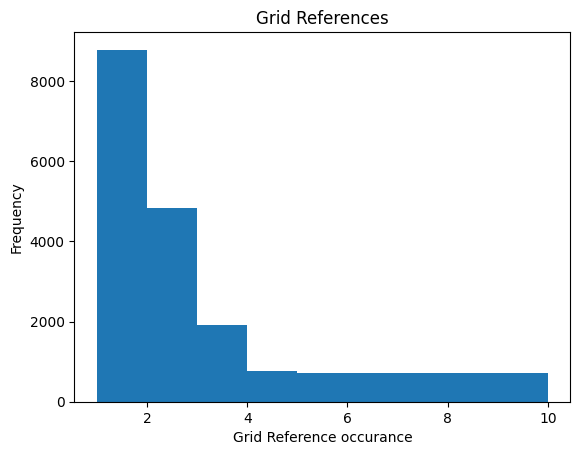

In [108]:
bins = [1, 2,3,4, 5, 10]
df['Grid Ref'].value_counts().plot.hist(bins=bins)
plt.xlabel('Grid Reference occurance')
plt.title('Grid References')
plt.show()

#### We can see that about 9000, out of the 32000 are unique gridpoints points meaning the other 78 % of gridpoints cover more than 1 Postcode. We see this in the table below where the Grid reference contains various postcodes.




In [22]:
df[df['Grid Ref'] == 'TQ485860'].head()

Postcode In Use?   Latitude  Longitude  Easting  Northing  Grid Ref  \
23394  RM10 7DE     Yes  51.553494   0.141982   548600    186019  TQ485860   
32588   RM9 5TR     Yes  51.553765   0.141332   548554    186048  TQ485860   
32589   RM9 5TS     Yes  51.553778   0.141636   548575    186050  TQ485860   
32595   RM9 5UH     Yes  51.553493   0.141954   548598    186019  TQ485860   
32812   RM9 9GR     Yes  51.553493   0.141954   548598    186019  TQ485860   

               County              District      Ward  ...  \
23394  Greater London  Barking and Dagenham  Parsloes  ...   
32588  Greater London  Barking and Dagenham  Parsloes  ...   
32589  Greater London  Barking and Dagenham  Parsloes  ...   
32595  Greater London  Barking and Dagenham  Parsloes  ...   
32812  Greater London  Barking and Dagenham  Parsloes  ...   

              Police force          Water company    Plus Code Average Income  \
23394  Metropolitan Police  Essex & Suffolk Water  9F32H43R+9Q          40900   
32588  Metropolitan Police  Essex & Suffolk Water  9F32H43R+GG          40900   
32589  Metropolitan Police  Essex & Suffolk Water  9F32H43R+GM          40900   
32595  Metropolitan Police  Essex & Suffolk Water  9F32H43R+9Q          40900   
32812  Metropolitan Police  Essex & Suffolk Water  9F32H43R+9Q          40900   

      Sewage Company Travel To Work Area                         ITL level 2  \
23394   Thames Water              London  Outer London - East and North East   
32588   Thames Water              London  Outer London - East and North East   
32589   Thames Water              London  Outer London - East and North East   
32595   Thames Water              London  Outer London - East and North East   
32812   Thames Water              London  Outer London - East and North East   

                           ITL level 3  \
23394  Barking & Dagenham and Havering   
32588  Barking & Dagenham and Havering   
32589  Barking & Dagenham and Havering   
32595  Barking & Dagenham and Havering   
32812  Barking & Dagenham and Havering   

                                                   UPRNs  Distance to sea  
23394                                        10092813112          21.6027  
32588  100053513,100053514,100053516,100053517,100053...          21.6567  
32589  100009955,100009956,100009957,100009958,100009...          21.6393  
32595                                          100053499          21.6043  
32812                                        10015066909          21.6043  

[5 rows x 53 columns]

# Investigating Postcodes

In [5]:
df['Postcode'].value_counts()

Postcode
E1 0AA     1
IG8 0EA    1
IG8 0QN    1
IG8 0QL    1
IG8 0QJ    1
          ..
E20 1EX    1
E20 1EW    1
E20 1ET    1
E20 1ES    1
RM9 9SZ    1
Name: count, Length: 32834, dtype: int64

####  We have 32000 distinct postcodes, so we need to find a way to group these together. The idea is if we strip the last letter of the postcode e.g. from IG1 4EU to IG1 4E will create at small cluster that represents a group of postcodes. This will give us approximate data for that subgroup, whilst reducing our costs as we only need to make API calls for the subgroup's coordinates as opposed to each individual entry. We can also apply the same concept to the grid references as shown below. 

In [34]:
ct = set(map(lambda x: x[:-1],df['Postcode'])) # We map x to itself with the last element of the string removed. 
ct1 = set(map(lambda x: x[:-1],df['Grid Ref'])) # Set command gets the distinct values

In [35]:
print(f'We have {len(ct)} unique Postcodes groups') 
print(f'We have {len(ct1)} unique Grid References groups')

We have 2847 unique Postcodes groups
We have 3448 unique Grid References groups


#### The idea was to use this to get a base number for the clusters. As the postcode groups have fewer points they may be a better option to use postcodes to determine our number of clusters as opposed to using Grid references.

## The relevant columns for out analysis are:

- Postcode
- Latitude
- Longitude
- Grid ref

A lot of these columns could have been utilised for analysis, however in this project we just want the required columns to get the data we need from the APIs.

In [134]:
df.columns

Index(['Postcode', 'In Use?', 'Latitude', 'Longitude', 'Easting', 'Northing',
       'Grid Ref', 'County', 'District', 'Ward', 'District Code', 'Ward Code',
       'Country', 'County Code', 'Constituency', 'Introduced', 'Terminated',
       'Parish', 'National Park', 'Population', 'Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Constituency Code',
       'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station', 'Postcode area',
       'Postcode district', 'Police force', 'Water company', 'Plus Code',
       'Average Income', 'Sewage Company', 'Travel To Work Area',
       'ITL level 2', 'ITL level 3', 'UPRNs', 'Distance to sea'],
      dtype='object')

In [135]:
df.head()

Postcode In Use?   Latitude  Longitude  Easting  Northing  Grid Ref  \
0   E1 0AA     Yes  51.512497  -0.052098   535267    181084  TQ352810   
1   E1 0AD     Yes  51.512910  -0.055323   535042    181124  TQ350811   
2   E1 0AE     Yes  51.510671  -0.052594   535238    180880  TQ352808   
3   E1 0AF     Yes  51.510864  -0.051161   535337    180904  TQ353809   
4   E1 0AG     Yes  51.513392  -0.054034   535130    181180  TQ351811   

           County       District      Ward  ...         Police force  \
0  Greater London  Tower Hamlets  Shadwell  ...  Metropolitan Police   
1  Greater London  Tower Hamlets  Shadwell  ...  Metropolitan Police   
2  Greater London  Tower Hamlets  Shadwell  ...  Metropolitan Police   
3  Greater London  Tower Hamlets  Shadwell  ...  Metropolitan Police   
4  Greater London  Tower Hamlets  Shadwell  ...  Metropolitan Police   

  Water company    Plus Code Average Income Sewage Company  \
0  Thames Water  9C3XGW6X+X5          43200            NaN   
1  Thames Water  9C3XGW7V+5V          43200            NaN   
2  Thames Water  9C3XGW6W+7X          62600            NaN   
3  Thames Water  9C3XGW6X+8G          43200            NaN   
4  Thames Water  9C3XGW7W+99          43200            NaN   

  Travel To Work Area          ITL level 2    ITL level 3  \
0              London  Inner London - East  Tower Hamlets   
1              London  Inner London - East  Tower Hamlets   
2              London  Inner London - East  Tower Hamlets   
3              London  Inner London - East  Tower Hamlets   
4              London  Inner London - East  Tower Hamlets   

                                               UPRNs  Distance to sea  
0  6027801,6027802,6029659,6029660,6029661,602966...          32.6997  
1  6155749,6155753,6158505,6195654,6195655,619565...          32.9273  
2  6024508,6024509,6024510,6024511,6024512,602451...          32.6950  
3  6024544,6024545,6024546,6024547,6024548,602454...          32.6017  
4  6356292,6356293,6356294,6356295,6356296,635629...          32.8502  

[5 rows x 53 columns]

In [112]:
df=df[['Postcode', 'Latitude', 'Longitude', 'Grid Ref', 'Nearest station', 'Distance to station', 'Average Income']]

In [24]:
df.isnull().sum()

Postcode               0
Latitude               0
Longitude              0
Grid Ref               0
Nearest station        0
Distance to station    0
Average Income         0
dtype: int64

We can see that there are no missing values in the data so can proceed

The following graph show the points with latitide and longitude. It is difficult to see these using MatplotLib so we instead use the Plotly library which can map the points on an actaul map allowing us to see areas, aswell as the ability to zoom into areas, as seen below


In [109]:
fig = px.scatter_mapbox(df,
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Postcode",
                        zoom=8,
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Let us compare the time difference between the two points furthest away in the 'IG1 3' area

In [25]:
t1= df[df['Postcode'].str.contains('IG1 3')]
t1

Postcode   Latitude  Longitude  Grid Ref Nearest station  \
17267  IG1 3AA  51.559439   0.069288  TQ435865          Ilford   
17268  IG1 3AB  51.559890   0.069152  TQ435865          Ilford   
17269  IG1 3AD  51.559358   0.068204  TQ434865          Ilford   
17270  IG1 3AE  51.559207   0.067577  TQ434865          Ilford   
17271  IG1 3AF  51.559165   0.065859  TQ433864          Ilford   
...        ...        ...        ...       ...             ...   
17451  IG1 3TX  51.571382   0.051217  TQ422878       Redbridge   
17452  IG1 3TY  51.572165   0.049679  TQ421879       Redbridge   
17453  IG1 3TZ  51.573309   0.048028  TQ420880       Redbridge   
17454  IG1 3UA  51.573965   0.046989  TQ419881       Redbridge   
17455  IG1 3UB  51.574362   0.046430  TQ419881       Redbridge   

       Distance to station  Average Income  
17267             0.044965           46100  
17268             0.089118           46100  
17269             0.040979           46100  
17270             0.076895           46100  
17271             0.195261           46100  
...                    ...             ...  
17451             0.684515           50200  
17452             0.552802           50200  
17453             0.385428           50200  
17454             0.288744           50200  
17455             0.234000           50200  

[189 rows x 7 columns]

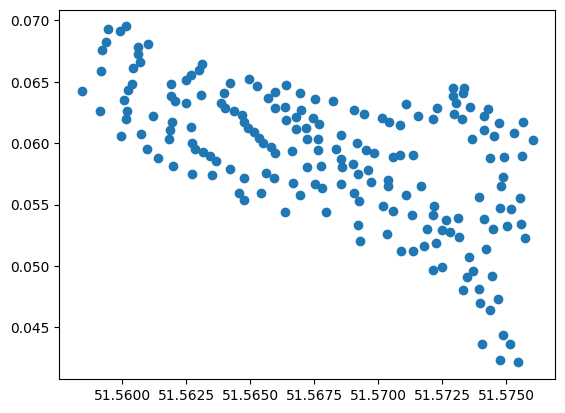

In [347]:
plt.scatter(x=t1['Latitude'], y=t1['Longitude'])
plt.show()

In [349]:
t1[['Latitude', 'Longitude']].mean()

Latitude     51.568200
Longitude     0.058847
dtype: float64

The two furthest points had a distance of approximately 30 mins via walking but on google maps we can see that there is a station on either side, allowing for easy of use via trains, and many areas in east London are similar, with train stations scattered all around. Lets find the mean of points and re-evaluate, 

IG1 3AA is a 11 min bus and 17 min walk from the cluster centre, and IG1 3UB is 13 min Bus journey and 17 minute walk from the cluster centre, so we can see the times can deviate from the centre by ~ 15 minutes, however as mentioned due to the vast number of station around, the transit time is not likely to exceed this variaition and will likely be lower.

We are assuming that up to 15 minutes in variation is reasonable and we will continue the rest of the prject based on this assumption 


# KMeans clustering

We will use the number of unique postcode groups from the previous section to determine the number of clusters to use

In [11]:
kmean = KMeans(n_clusters = 2847) # running kmeans with 2847 clusters which was the number of unique postcode groups 
kmean.fit(df[['Latitude', 'Longitude']])

KMeans(n_clusters=2847)

In [115]:
y_predicted=kmean.fit_predict(df[['Latitude', 'Longitude']])
# not acc predicting anything just need coordinates
df['Cluster_ID'] = y_predicted

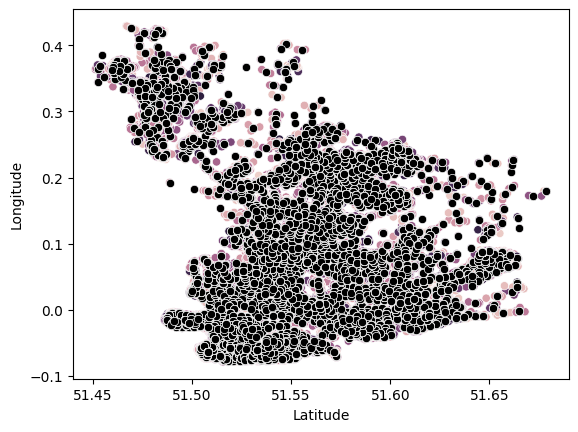

In [116]:
df['Cluster Latitude'] = kmean.cluster_centers_[df['Cluster_ID'],0]
df['Cluster Longitude'] = kmean.cluster_centers_[df['Cluster_ID'],1]

sns.scatterplot(x=df['Latitude'],y=df['Longitude'],hue=df['Cluster_ID'], markers='x', legend=False)
sns.scatterplot(x=df['Cluster Latitude'], y=df['Cluster Longitude'], color='black')
plt.show()


In [117]:
fig2 = px.scatter_mapbox(df,
                        lat="Cluster Latitude",
                        lon="Cluster Longitude",
                        hover_name="Cluster_ID",
                        zoom=8,
                        height=800,
                        width=800)

fig2.update_layout(mapbox_style="open-street-map")
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

#### While this is looking accurate and representative of the areas, we are using 2800 clusters, and will obtain a walking, driving, and transit time later, giving us a total of around 8400 requests at a cost of $0.004 per request which can be costly. As many clusters are close together, we will try to reduce the number of clusters while maintaining the level of accuracy.

#### We will re-run the machine learning algorithm, but this time with 30 % fewer clusters

In [14]:
kmean = KMeans(n_clusters = 2000) #re-run kmeans with only 2000 clusters
kmean.fit(df[['Latitude', 'Longitude']])

y_predicted=kmean.fit_predict(df[['Latitude', 'Longitude']])

df['Cluster_ID'] = y_predicted
df['Cluster Latitude'] = kmean.cluster_centers_[df['Cluster_ID'],0]
df['Cluster Longitude'] = kmean.cluster_centers_[df['Cluster_ID'],1]

In [15]:
fig2 = px.scatter_mapbox(df,
                        lat="Cluster Latitude",
                        lon="Cluster Longitude",
                        hover_name="Cluster_ID",
                        zoom=8,
                        height=800,
                        width=800)

fig2.update_layout(mapbox_style="open-street-map")
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

### Comparing distances between clusters

- 244 to 1305 is a 10 min walk
- 1297 to 27 is a 7 min walk
- 1720 to 199 is a 7 min walk
- 845 to 1971 is a 7 minute walk 
- 596 to 1430 is a 6 minute walk

#### We have a theme of 5-10 minute walking difference between clusters which is reasonble, and will bring number of requests down to 6000, and thus the total cost to $24. We can also say that the clusters seem to be equally spread out for the most part, of course where there is more greenery the clusters are likely to be slightly more spread out.


To avoid re-running k-means we outputted the clustering as a CSV and will use this when returning to this project

In [29]:
df = pd.read_csv('Table.csv', index_col = 0)
df.head()

Postcode   Latitude  Longitude  Grid Ref Nearest station  \
0   E1 0AA  51.512497  -0.052098  TQ352810        Shadwell   
1   E1 0AD  51.512910  -0.055323  TQ350811        Shadwell   
2   E1 0AE  51.510671  -0.052594  TQ352808        Shadwell   
3   E1 0AF  51.510864  -0.051161  TQ353809        Shadwell   
4   E1 0AG  51.513392  -0.054034  TQ351811        Shadwell   

   Distance to station  Average Income  Cluster_ID  Cluster Latitude  \
0             0.358964           43200        1637         51.511418   
1             0.210212           43200         457         51.513162   
2             0.307178           62600        1637         51.511418   
3             0.401158           43200        1959         51.510796   
4             0.306344           43200         457         51.513162   

   Cluster Longitude  
0          -0.053256  
1          -0.055798  
2          -0.053256  
3          -0.050508  
4          -0.055798

# Implementing Google Maps API

In [166]:
import requests
import json

R_lat = 51.5415 # Latitude for Stratford station
R_long = 0.0028 # Longitude for Stratford station

#importing our API key

api_file = open('key.txt', 'r')
api_key = api_file.read()  #Opens file containing API key, assigns to variable, and closes the file.
api_file.close()

In [35]:
df2 = df[['Cluster_ID', 'Latitude', 'Longitude', 'Distance to station', 'Average Income','Cluster Latitude','Cluster Longitude']].groupby('Cluster_ID').mean()
df2

Latitude  Longitude  Distance to station  Average Income  \
Cluster_ID                                                              
0           51.507398   0.069838             0.249289    46300.000000   
1           51.559826   0.243750             0.498645    57375.000000   
2           51.583014  -0.028916             0.341982    50900.000000   
3           51.589322   0.082070             0.593095    49273.076923   
4           51.490828   0.338506             1.991851    44688.888889   
...               ...        ...                  ...             ...   
1995        51.516453  -0.060376             0.342369    59732.000000   
1996        51.577450   0.175458             0.615979    44645.454545   
1997        51.643831   0.084252             0.211039    41300.000000   
1998        51.599542   0.233950             0.708289    44791.666667   
1999        51.485572   0.371954             2.792734    35900.000000   

            Cluster Latitude  Cluster Longitude  
Cluster_ID                                       
0                  51.507398           0.069838  
1                  51.559826           0.243750  
2                  51.583014          -0.028916  
3                  51.589322           0.082070  
4                  51.490828           0.338506  
...                      ...                ...  
1995               51.516453          -0.060376  
1996               51.577450           0.175458  
1997               51.643831           0.084252  
1998               51.599542           0.233950  
1999               51.485572           0.371954  

[2000 rows x 6 columns]

In [41]:
df3=df2.loc[::] # We make a copy df3 so we do not mofidy df2 incase we make any errors 
df3

Latitude  Longitude  Distance to station  Average Income  \
Cluster_ID                                                              
0           51.507398   0.069838             0.249289    46300.000000   
1           51.559826   0.243750             0.498645    57375.000000   
2           51.583014  -0.028916             0.341982    50900.000000   
3           51.589322   0.082070             0.593095    49273.076923   
4           51.490828   0.338506             1.991851    44688.888889   
...               ...        ...                  ...             ...   
1995        51.516453  -0.060376             0.342369    59732.000000   
1996        51.577450   0.175458             0.615979    44645.454545   
1997        51.643831   0.084252             0.211039    41300.000000   
1998        51.599542   0.233950             0.708289    44791.666667   
1999        51.485572   0.371954             2.792734    35900.000000   

            Cluster Latitude  Cluster Longitude  
Cluster_ID                                       
0                  51.507398           0.069838  
1                  51.559826           0.243750  
2                  51.583014          -0.028916  
3                  51.589322           0.082070  
4                  51.490828           0.338506  
...                      ...                ...  
1995               51.516453          -0.060376  
1996               51.577450           0.175458  
1997               51.643831           0.084252  
1998               51.599542           0.233950  
1999               51.485572           0.371954  

[2000 rows x 6 columns]

## Extraction of distance between postcode and station usng Google maps API

In [ ]:
a=[]
transport = ['driving', 'walking', 'transit'] # The 3 differnet modes of transports that we will iterate through within each iteration of the dataframe rows
for y in range(0,len(df3)):
    for x in transport:
        url ="https://maps.googleapis.com/maps/api/distancematrix/json?origins={}%2C{}&destinations={}%2C{}&mode={}&key={}".format(R_lat, R_long,df3.loc[y][0],df3.loc[y][1],x,api_key) # 0 and 1 array access latitude and longitude
        response = requests.request("GET", url) # stores the result fromm the response 
        a.append(response.json()) # appends json string to list

In [125]:
a[0:6]

[{'destination_addresses': ['University Way, London E16, UK'],
  'origin_addresses': ['69 Broadway, London E15 4BQ, UK'],
  'rows': [{'elements': [{'distance': {'text': '7.2 km', 'value': 7243},
      'duration': {'text': '18 mins', 'value': 1079},
      'status': 'OK'}]}],
  'status': 'OK'},
 {'destination_addresses': ['University Way, London E16, UK'],
  'origin_addresses': ['69 Broadway, London E15 4BQ, UK'],
  'rows': [{'elements': [{'distance': {'text': '6.9 km', 'value': 6879},
      'duration': {'text': '1 hour 26 mins', 'value': 5145},
      'status': 'OK'}]}],
  'status': 'OK'},
 {'destination_addresses': ['University Way, London E16, UK'],
  'origin_addresses': ['69 Broadway, London E15 4BQ, UK'],
  'rows': [{'elements': [{'distance': {'text': '7.1 km', 'value': 7072},
      'duration': {'text': '36 mins', 'value': 2162},
      'status': 'OK'}]}],
  'status': 'OK'},
 {'destination_addresses': ['98 Berkeley Dr, Hornchurch RM11 3PZ, UK'],
  'origin_addresses': ['69 Broadway, Lo

#### The below code extracts the time and duration for each of the distances 

In [ ]:
b=[]
c=[]
for i in range(0, 3*len(df3)):
    try:
        b.append(int(round(a[i]['rows'][0]['elements'][0]['duration']['value']/60))) # here we extracts all of the times in minutes
    except:
        b.append(np.nan)

for i in range(0, 3*len(df3)):
    try:
        c.append(round(a[i]['rows'][0]['elements'][0]['distance']['value']/1000,2)) # Here we extract all of the distance in Kilometers
    except:
        c.append(np.nan)

driving = b[::3]  # the first element is for driving, second walking, and third for transit, and so on hence every third element fromt the curent position is for the same mode of transport.
walking =  b[1::3]
transit = b[2::3]

driving_d = c[::3]
walking_d = c[1::3]
transit_d = c[2::3]

In [ ]:
walking_d[0:5]

[6.88, 18.27, 6.24, 9.07, 27.36]

In [ ]:
headers = ['Walking_distance (KM)', 'Walking time (Min)',
            'Driving_distance (KM)', 'Driving_time (Min)',
            'Transit_distance (KM)', 'Transit_time (Min)']

final = pd.DataFrame(list(zip(walking_d, walking, driving_d, driving, transit_d, transit )))
final.columns = headers

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### We need to fix the missing entries that were not returned from the API

In [59]:
final = pd.read_csv('final.csv', index_col=0)
final.rename(columns = {'Transit_time (KM)' : 'Transit_time (Min)'}, inplace = True)

In [61]:
final2= final.copy()
final2.isna().sum()

Walking_distance (KM)     1
Walking time (Min)        1
Driving_distance (KM)     1
Driving_time (Min)        1
Transit_distance (KM)    12
Transit_time (Min)       12
dtype: int64

For one of the clusters the API failed, so we have to manually update this very small subset of errors

In [53]:
final2.iloc[1208] # This cluster is valid but the API did not gather the details for some reason, so instead we enter the metrics manually which we work out from Google maps.

Walking_distance (KM)   NaN
Walking time (Min)      NaN
Driving_distance (KM)   NaN
Driving_time (Min)      NaN
Transit_distance (KM)   NaN
Transit_time (Min)      NaN
Name: 1208, dtype: float64

In [65]:
final2.loc[1208, 'Walking_distance (KM)'] = 11.52
final2.loc[1208, 'Walking time (Min)'] = 143
final2.loc[1208, 'Driving_distance (KM)'] = 16.32
final2.loc[1208, 'Driving_time (Min)'] = 28
final2.loc[1208, 'Transit_distance (KM)'] = 10.4
final2.loc[1208, 'Transit_time (Min)'] = 44

In [66]:
final2.isna().sum()

Walking_distance (KM)     0
Walking time (Min)        0
Driving_distance (KM)     0
Driving_time (Min)        0
Transit_distance (KM)    11
Transit_time (Min)       11
dtype: int64

In [67]:
final2[final2['Transit_distance (KM)'].isnull()]

Walking_distance (KM)  Walking time (Min)  Driving_distance (KM)  \
111                   23.30               291.0                  31.87   
332                    7.83                97.0                   9.93   
423                   23.11               289.0                  30.86   
566                   20.01               250.0                  19.66   
633                   22.18               278.0                  33.03   
673                   27.02               335.0                  28.16   
1017                  22.79               284.0                  30.54   
1103                  21.78               273.0                  33.03   
1398                  32.36               404.0                  37.37   
1807                  23.49               293.0                  31.24   
1943                  14.72               185.0                  18.71   

      Driving_time (Min)  Transit_distance (KM)  Transit_time (Min)  
111                 35.0                    NaN                 NaN  
332                 23.0                    NaN                 NaN  
423                 36.0                    NaN                 NaN  
566                 30.0                    NaN                 NaN  
633                 37.0                    NaN                 NaN  
673                 35.0                    NaN                 NaN  
1017                34.0                    NaN                 NaN  
1103                38.0                    NaN                 NaN  
1398                39.0                    NaN                 NaN  
1807                34.0                    NaN                 NaN  
1943                33.0                    NaN                 NaN

In [69]:
df[df['Cluster_ID'] == 111]

Postcode   Latitude  Longitude  Grid Ref Nearest station  \
30104  RM4 1EX  51.661308   0.225552  TQ540981       Brentwood   
30106  RM4 1HA  51.662372   0.227296  TQ541983       Brentwood   

       Distance to station  Average Income  Cluster_ID  Cluster Latitude  \
30104              7.35995           51300         111          51.66184   
30106              7.36356           51300         111          51.66184   

       Cluster Longitude  
30104           0.226424  
30106           0.226424

#### Some of the areas such as Brentwood are in more rural areas and hence google maps cannot calculate a route for them, and hence the API does not return any values
#### One thing we have not accounted for is many people actully now cycle to work too, and with the substantial traffic within London, this may be a more viable method of travelling, let us use the API to get this data and add it to our table   

In [ ]:
a1=[]
transport = ['bicycling'] # Extracts bicycle parameter from the API
for y in range(0,len(df3)):
    for x in transport:
        url ="https://maps.googleapis.com/maps/api/distancematrix/json?origins={}%2C{}&destinations={}%2C{}&mode={}&key={}".format(R_lat, R_long,df3.loc[y][0],df3.loc[y][1],x,api_key)
        response = requests.request("GET", url)
        a1.append(response.json())

In [ ]:
a1[0:2]

[{'destination_addresses': ['University Way, London E16, UK'],
  'origin_addresses': ['69 Broadway, London E15 4BQ, UK'],
  'rows': [{'elements': [{'distance': {'text': '7.7 km', 'value': 7655},
      'duration': {'text': '28 mins', 'value': 1667},
      'status': 'OK'}]}],
  'status': 'OK'},
 {'destination_addresses': ['98 Berkeley Dr, Hornchurch RM11 3PZ, UK'],
  'origin_addresses': ['69 Broadway, London E15 4BQ, UK'],
  'rows': [{'elements': [{'distance': {'text': '19.8 km', 'value': 19803},
      'duration': {'text': '1 hour 7 mins', 'value': 4014},
      'status': 'OK'}]}],
  'status': 'OK'}]

Similar to before we extact the values from the response and add them to our DataFrame 

In [ ]:
b1=[] # Similar to before we define empty lists and extract the element correlating to the time and distance respectively.
c1=[]
for i in range(0, len(df3)):
    try:
        b1.append(int(round(a1[i]['rows'][0]['elements'][0]['duration']['value']/60)))
    except:
        b1.append(np.nan)

for i in range(0, len(df3)):
    try:
        c1.append(round(a1[i]['rows'][0]['elements'][0]['distance']['value']/1000,2))
    except:
        c1.append(np.nan)
        
final2['Cycling Time (Min)'] = b1
final2['Cycling Distance (KM)'] = c1


In [ ]:
final2.isna().sum()
# We can see we having one cluster which had an error so we update this manually too.

Walking_distance (KM)     0
Walking time (Min)        0
Driving_distance (KM)     0
Driving_time (Min)        0
Transit_distance (KM)    11
Transit_time (KM)        11
Cycling Distance (KM)     1
Cycling Time (Min)        1
dtype: int64

In [ ]:
final2[final2['Cycling Time (Min)'].isnull() ==True]
# We can see the issues are at clusters 1208, the 11 transit errors are from before

Walking_distance (KM)  Walking time (Min)  Driving_distance (KM)  \
1208                  11.52               143.0                  16.32   

      Driving_time (Min)  Transit_distance (KM)  Transit_time (KM)  \
1208                28.0                   10.4               44.0   

      Cycling Distance (KM)  Cycling Time (Min)  
1208                    NaN                 NaN

In [ ]:
final2.loc[1208, 'Cycling Distance (KM)'] = 12.16
final2.loc[1208, 'Cycling Time (Min)'] = 41

In [ ]:
final2.isna().sum()

Walking_distance (KM)     0
Walking time (Min)        0
Driving_distance (KM)     0
Driving_time (Min)        0
Transit_distance (KM)    11
Transit_time (KM)        11
Cycling Distance (KM)     0
Cycling Time (Min)        0
dtype: int64

In [ ]:
# As all is working now we define final2 back as final 
final=final2.reset_index()
final

index  Walking_distance (KM)  Walking time (Min)  Driving_distance (KM)  \
0         0                   6.88                86.0                   7.24   
1         1                  18.27               231.0                  28.02   
2         2                   6.24                78.0                   6.59   
3         3                   9.07               113.0                  14.59   
4         4                  27.36               343.0                  28.10   
...     ...                    ...                 ...                    ...   
1995   1995                   6.50                81.0                   5.55   
1996   1996                  12.95               162.0                  21.20   
1997   1997                  13.85               175.0                  19.95   
1998   1998                  17.95               227.0                  25.87   
1999   1999                  29.76               373.0                  33.50   

      Driving_time (Min)  Transit_distance (KM)  Transit_time (KM)  \
0                   18.0                   7.07               36.0   
1                   39.0                  19.48               48.0   
2                   21.0                   6.59               35.0   
3                   23.0                   9.64               39.0   
4                   34.0                  30.27               76.0   
...                  ...                    ...                ...   
1995                17.0                   6.48               20.0   
1996                32.0                  15.12               40.0   
1997                22.0                  15.60               33.0   
1998                38.0                  19.28               48.0   
1999                36.0                  39.25               87.0   

      Cycling Distance (KM)  Cycling Time (Min)  
0                      7.66                28.0  
1                     19.80                67.0  
2                      6.73                22.0  
3                     10.72                37.0  
4                     29.38                95.0  
...                     ...                 ...  
1995                   5.59                17.0  
1996                  13.10                44.0  
1997                  15.54                53.0  
1998                  18.47                61.0  
1999                  31.95               104.0  

[2000 rows x 9 columns]

In [ ]:
final.rename(columns ={ 'index' : 'Cluster_ID'}, inplace=True)
final[final['Cluster_ID'] == 265]

Cluster_ID  Walking_distance (KM)  Walking time (Min)  \
265         265                  21.44               268.0   

     Driving_distance (KM)  Driving_time (Min)  Transit_distance (KM)  \
265                  21.97                29.0                  25.46   

     Transit_time (KM)  Cycling Distance (KM)  Cycling Time (Min)  
265               59.0                  24.41                76.0

#### We join this back with the original table

In [ ]:
fin=df.join(final, on = 'Cluster_ID', lsuffix="_x", rsuffix= "_y")
fin.isna().sum()

Postcode                  0
Latitude                  0
Longitude                 0
Grid Ref                  0
Nearest station           0
Distance to station       0
Average Income            0
Cluster_ID_x              0
Cluster Latitude          0
Cluster Longitude         0
Cluster_ID_y              0
Walking_distance (KM)     0
Walking time (Min)        0
Driving_distance (KM)     0
Driving_time (Min)        0
Transit_distance (KM)    58
Transit_time (KM)        58
Cycling Distance (KM)     0
Cycling Time (Min)        0
dtype: int64

In [ ]:
df_fin=pd.merge(
    df,
    final,
    how="inner",
    on='Cluster_ID',
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
df_fin.to_csv('Full.csv') # We save the csv to avoid re-running the process

In [36]:
df_final = pd.read_csv('Full.csv', index_col=0, sep=',')
df_final.rename(columns = {'Transit_time (KM)' : 'Transit_time (Min)'}, inplace=True) # There was a naming convention error from the bicyle csection which we correct here.
df_final.head()

Postcode   Latitude  Longitude  Grid Ref Nearest station  \
0   E1 0AA  51.512497  -0.052098  TQ352810        Shadwell   
1   E1 0AE  51.510671  -0.052594  TQ352808        Shadwell   
2   E1 0AJ  51.511258  -0.052785  TQ352809        Shadwell   
3   E1 0AL  51.511002  -0.052522  TQ352809        Shadwell   
4   E1 0AN  51.511296  -0.052365  TQ352809        Shadwell   

   Distance to station  Average Income  Cluster_ID  Cluster Latitude  \
0             0.358964           43200        1637         51.511418   
1             0.307178           62600        1637         51.511418   
2             0.285946           62600        1637         51.511418   
3             0.305896           62600        1637         51.511418   
4             0.314954           62600        1637         51.511418   

   Cluster Longitude  Walking_distance (KM)  Walking time (Min)  \
0          -0.053256                   6.33                79.0   
1          -0.053256                   6.33                79.0   
2          -0.053256                   6.33                79.0   
3          -0.053256                   6.33                79.0   
4          -0.053256                   6.33                79.0   

   Driving_distance (KM)  Driving_time (Min)  Transit_distance (KM)  \
0                   6.19                18.0                   7.62   
1                   6.19                18.0                   7.62   
2                   6.19                18.0                   7.62   
3                   6.19                18.0                   7.62   
4                   6.19                18.0                   7.62   

   Transit_time (Min)  Cycling Distance (KM)  Cycling Time (Min)  
0                29.0                   5.78                18.0  
1                29.0                   5.78                18.0  
2                29.0                   5.78                18.0  
3                29.0                   5.78                18.0  
4                29.0                   5.78                18.0

In [37]:
df_final.shape # We can see we have maintained the number of rows and none from the original dataframe and none of them are missing 

(32834, 18)

In [38]:
df_final.isnull().sum()

Postcode                  0
Latitude                  0
Longitude                 0
Grid Ref                  0
Nearest station           0
Distance to station       0
Average Income            0
Cluster_ID                0
Cluster Latitude          0
Cluster Longitude         0
Walking_distance (KM)     0
Walking time (Min)        0
Driving_distance (KM)     0
Driving_time (Min)        0
Transit_distance (KM)    58
Transit_time (Min)       58
Cycling Distance (KM)     0
Cycling Time (Min)        0
dtype: int64

#### We have in total 58 missing values for transit out of 32000 rows which is negligable and can be ignored, as discussed earlier this was due to rurual errors not receiveing a results from the API call, and not to do with any lost data during the joins. 

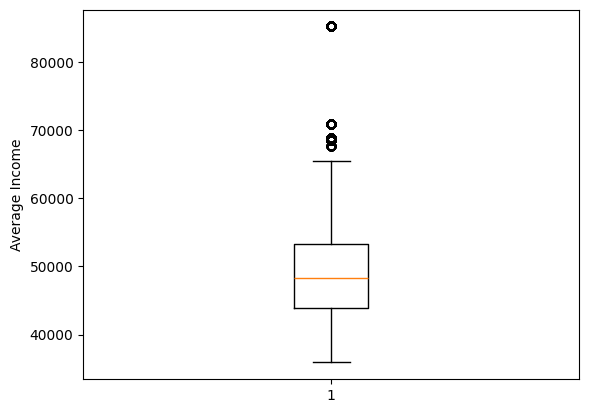

In [39]:
#plt.style.use('seaborn-whitegrid')
plt.boxplot(df_final['Average Income'])
plt.ylabel('Average Income')
plt.show()

Distance to station  Average Income
Distance to station             1.000000       -0.204628
Average Income                 -0.204628        1.000000

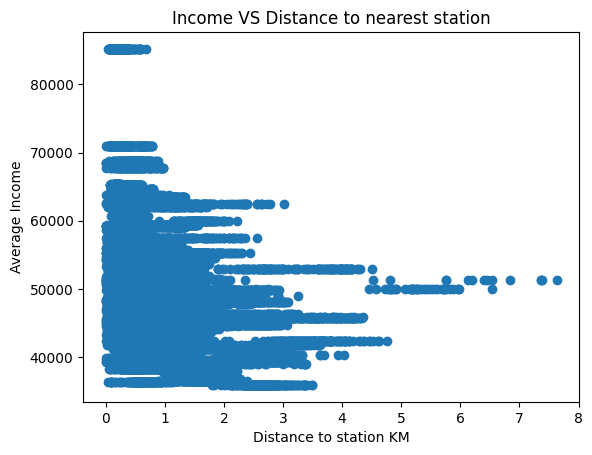

In [104]:
plt.scatter(x=df_final['Distance to station'], y=df_final['Average Income'])
plt.xlabel('Distance to station KM')
plt.ylabel('Average Income')
plt.title('Income VS Distance to nearest station')

df2[['Distance to station', 'Average Income']].corr()

#### One theory people could have argued that those with higher income may tnend to live nearer to stations as these houses may be more expensive, however looking at the above graph we can see that is not necesserily the case, and in particular we have a weak correlation of only 0.2

In [105]:
df_final.head()

Postcode   Latitude  Longitude  Grid Ref Nearest station  \
0   E1 0AA  51.512497  -0.052098  TQ352810        Shadwell   
1   E1 0AE  51.510671  -0.052594  TQ352808        Shadwell   
2   E1 0AJ  51.511258  -0.052785  TQ352809        Shadwell   
3   E1 0AL  51.511002  -0.052522  TQ352809        Shadwell   
4   E1 0AN  51.511296  -0.052365  TQ352809        Shadwell   

   Distance to station  Average Income  Cluster_ID  Cluster Latitude  \
0             0.358964           43200        1637         51.511418   
1             0.307178           62600        1637         51.511418   
2             0.285946           62600        1637         51.511418   
3             0.305896           62600        1637         51.511418   
4             0.314954           62600        1637         51.511418   

   Cluster Longitude  Walking_distance (KM)  Walking time (Min)  \
0          -0.053256                   6.33                79.0   
1          -0.053256                   6.33                79.0   
2          -0.053256                   6.33                79.0   
3          -0.053256                   6.33                79.0   
4          -0.053256                   6.33                79.0   

   Driving_distance (KM)  Driving_time (Min)  Transit_distance (KM)  \
0                   6.19                18.0                   7.62   
1                   6.19                18.0                   7.62   
2                   6.19                18.0                   7.62   
3                   6.19                18.0                   7.62   
4                   6.19                18.0                   7.62   

   Transit_time (Min)  Cycling Distance (KM)  Cycling Time (Min)  
0                29.0                   5.78                18.0  
1                29.0                   5.78                18.0  
2                29.0                   5.78                18.0  
3                29.0                   5.78                18.0  
4                29.0                   5.78                18.0

In [280]:
x=input("enter your postcode without any spaces")
d=str(x)
d=d.upper()
if d[-4:] != ' ':
    if len(d) == 6:
        d= d[0:3] + " " + d[-3:]
    elif len(d) == 7:
        d= d[0:4] + " " + d[-3:]

print ("Here the following times for postcode: " + d)

df_final.loc[df_final['Postcode'] == d]

Here the following times for postcode: IG1 3TG


Postcode   Latitude  Longitude  Grid Ref Nearest station  \
17632  IG1 3TG  51.559106   0.062595  TQ430864          Ilford   

       Distance to station  Average Income  Cluster_ID  Cluster Latitude  \
17632             0.420754           46100          71         51.560882   

       Cluster Longitude  Walking_distance (KM)  Walking time (Min)  \
17632           0.061513                   5.41                68.0   

       Driving_distance (KM)  Driving_time (Min)  Transit_distance (KM)  \
17632                   5.41                18.0                   5.31   

       Transit_time (Min)  Cycling Distance (KM)  Cycling Time (Min)  
17632                28.0                   5.41                18.0

#### The idea above essentally mirrors what google maps would have done has allowed us to find the distance and time taken between varying locations around east london and a set location. This on it's own would be of no use and not worth the credits we have used for the API calls, so let's take this a step further and also look into crime rates and house prices of varying postcodes.

# Joining with house prices and crime rate data

In [40]:
df_final['Postcode']

0         E1 0AA
1         E1 0AE
2         E1 0AJ
3         E1 0AL
4         E1 0AN
          ...   
32829    RM9 6YG
32830    RM9 6QD
32831    RM9 6QJ
32832    RM9 6RA
32833    RM9 6SA
Name: Postcode, Length: 32834, dtype: object

In [43]:
len(set(map(lambda x: x[:-2],df_final['Postcode']))) # We map x to itself with last 2 eleements of the string removed.

205

#### If we format out postcodes into subgroups by removing the last 2 letters, we can see we will have 205 unique points for the postcodes, which will also make it easy to visualise the different areas, as well as allow us to join our data with the new data we are about to introduce

In [320]:
house_prices = pd.read_csv('houses.csv')
house_prices = house_prices[['Postcode','Average House Price £000s']]
house_prices.columns = ['Postcode', 'Average Price £000s']
house_prices['Average Price £000s'] = house_prices['Average Price £000s'].apply(lambda x: str(x)[1:-1] if pd.notna(x) else x) # Formatting as a float  instead of a string and ignoring null values
house_prices = house_prices[['Postcode','Average Price £000s']]
house_prices.head()

Postcode Average Price £000s
0    E15 2                 443
1    RM1 1                 163
2    E20 3                 NaN
3     E6 2                 399
4    E11 4                 570

In [321]:
antisocial =  pd.read_csv('crime rates/antisocial_behabiour.csv', delimiter = '\t')
burglary = pd.read_csv('crime rates/burglary.csv', delimiter = '\t')
violent = pd.read_csv('crime rates/violent_crime.csv', delimiter = '\t') 

antisocial.rename(columns = {'postcode' : 'Postcode'}, inplace= True)
burglary.rename(columns = {'postcode' : 'Postcode'}, inplace= True)
violent.rename(columns = {'postcode' : 'Postcode'}, inplace= True)

In [322]:
# for simplicity let u join all the crime rate tables here <- this part here needs to change
crime = pd.merge(house_prices, antisocial, how = 'left', on='Postcode').merge(burglary, on = 'Postcode').merge(violent, on = 'Postcode') # merging the 3 crime tables into one as well as house prices
crime.rename(columns = {'Crime rate per 1000 workday people': 'Antisocial Crime rate per 1000 workday people'}, inplace=True)
crime = crime[['Postcode', 'Average Price £000s', 'Crime rate per 1000 workday people_x', 'Crime rate per 1000 workday people_y', 'Violent Crime rate per 1000 workday people']]
crime.rename(columns ={
                       'Crime rate per 1000 workday people_x': 'Antisocial Crime rate per 1000 workday people',
                       'Crime rate per 1000 workday people_y' : 'Burglary Crime rate per 1000 workday people',
                        }, inplace=True)
crime.sort_values(by='Postcode')
crime.head()

Postcode Average Price £000s  Antisocial Crime rate per 1000 workday people  \
0    E15 2                 443                                           97.0   
1    RM1 1                 163                                           64.0   
2     E6 2                 399                                           28.0   
3    E11 4                 570                                           33.0   
4     E5 9                 493                                           60.0   

   Burglary Crime rate per 1000 workday people  \
0                                           12   
1                                            5   
2                                            3   
3                                            5   
4                                           11   

   Violent Crime rate per 1000 workday people  
0                                          15  
1                                          10  
2                                           6  
3                                           3  
4                                          10

In [323]:
tempo = df_final.copy()

bt = []
for x in df_final['Postcode']:
    x=x[:-2]
    bt.append(x)
tempo['Postcode'] = bt

final_set = pd.merge(tempo, crime, how='left', on='Postcode')
final_set['Average Price £000s'] = final_set['Average Price £000s'].apply(lambda x: float(x))
final_set.head()

Postcode   Latitude  Longitude  Grid Ref Nearest station  \
0     E1 0  51.512497  -0.052098  TQ352810        Shadwell   
1     E1 0  51.510671  -0.052594  TQ352808        Shadwell   
2     E1 0  51.511258  -0.052785  TQ352809        Shadwell   
3     E1 0  51.511002  -0.052522  TQ352809        Shadwell   
4     E1 0  51.511296  -0.052365  TQ352809        Shadwell   

   Distance to station  Average Income  Cluster_ID  Cluster Latitude  \
0             0.358964           43200        1637         51.511418   
1             0.307178           62600        1637         51.511418   
2             0.285946           62600        1637         51.511418   
3             0.305896           62600        1637         51.511418   
4             0.314954           62600        1637         51.511418   

   Cluster Longitude  ...  Driving_distance (KM)  Driving_time (Min)  \
0          -0.053256  ...                   6.19                18.0   
1          -0.053256  ...                   6.19                18.0   
2          -0.053256  ...                   6.19                18.0   
3          -0.053256  ...                   6.19                18.0   
4          -0.053256  ...                   6.19                18.0   

   Transit_distance (KM)  Transit_time (Min)  Cycling Distance (KM)  \
0                   7.62                29.0                   5.78   
1                   7.62                29.0                   5.78   
2                   7.62                29.0                   5.78   
3                   7.62                29.0                   5.78   
4                   7.62                29.0                   5.78   

   Cycling Time (Min)  Average Price £000s  \
0                18.0                522.0   
1                18.0                522.0   
2                18.0                522.0   
3                18.0                522.0   
4                18.0                522.0   

   Antisocial Crime rate per 1000 workday people  \
0                                           52.0   
1                                           52.0   
2                                           52.0   
3                                           52.0   
4                                           52.0   

   Burglary Crime rate per 1000 workday people  \
0                                          5.0   
1                                          5.0   
2                                          5.0   
3                                          5.0   
4                                          5.0   

   Violent Crime rate per 1000 workday people  
0                                         3.0  
1                                         3.0  
2                                         3.0  
3                                         3.0  
4                                         3.0  

[5 rows x 22 columns]

In [324]:
final_set.drop(['Grid Ref', 'Nearest station'], axis=1, inplace=True)
# The two above columns are not necessary and are not of a numerica; format and would prevent us performinf the groupby
final_set2 = final_set.groupby('Postcode').mean()
final_set2.dropna(inplace=True)
final_set2.rename(columns ={'Antisocial Crime rate per 1000 workday people' : 'Antisocial Crime rate per 1000',
                            'Burglary Crime rate per 1000 workday people' : 'Burglary Crime rate per 1000',
                            'Violent Crime rate per 1000 workday people' : 'Violent Crime rate per 1000'
                            }, inplace= True)
final_set2 = final_set2.reset_index()
final_set2.head()

Postcode   Latitude  Longitude  Distance to station  Average Income  \
0     E1 0  51.513267  -0.049195             0.399075    50469.886364   
1     E1 1  51.515189  -0.064839             0.437373    63549.032258   
2     E1 2  51.514825  -0.058169             0.314142    51632.941176   
3     E1 3  51.518273  -0.049586             0.442814    46721.428571   
4     E1 4  51.522339  -0.045359             0.378078    47324.505929   

    Cluster_ID  Cluster Latitude  Cluster Longitude  Walking_distance (KM)  \
0  1106.005682         51.513261          -0.049189               5.945511   
1   956.109677         51.515060          -0.064948               6.855935   
2  1169.417647         51.514784          -0.058169               6.512882   
3  1040.057143         51.518371          -0.049713               5.650429   
4  1031.300395         51.522261          -0.045359               5.048498   

   Walking time (Min)  Driving_distance (KM)  Driving_time (Min)  \
0           73.960227               5.637045           16.585227   
1           85.838710               6.071806           19.483871   
2           80.847059               5.702353           17.658824   
3           70.335714               5.000571           14.700000   
4           63.146245               4.480277           13.071146   

   Transit_distance (KM)  Transit_time (Min)  Cycling Distance (KM)  \
0               7.210170           31.107955               5.604773   
1               7.220710           25.619355               6.095097   
2               7.016824           24.105882               5.700294   
3               6.066643           29.321429               4.975286   
4               5.341146           29.616601               4.417826   

   Cycling Time (Min)  Average Price £000s  Antisocial Crime rate per 1000  \
0           17.960227                522.0                            52.0   
1           19.477419                576.0                            71.0   
2           17.635294                579.0                            39.0   
3           15.307143                443.0                            44.0   
4           13.656126                459.0                            41.0   

   Burglary Crime rate per 1000  Violent Crime rate per 1000  
0                           5.0                          3.0  
1                           8.0                          6.0  
2                           6.0                          4.0  
3                           7.0                          1.0  
4                           7.0                          3.0

#### As seen earlier we had used our cluster center's coordinates to calculate the relatives time taken to stratforsdstation. Here we will the average of the coordinates for each of the postcodes to get a more accurate representation on the maps. The travel times will be the same as calculated from the previous section, and we will now look at how close the coordinates of the postcode's mean are to that of the cluster's mean. Alternatively we could have grouped by postcode first and then ran the coordinates through the google maps API, however as mentioned this was not in the initial scope of the project. 

In [325]:
import geopy.distance

coords_1 = (final_set2['Latitude'][0], final_set2['Longitude'][0])
coords_2 = (final_set2['Cluster Latitude'][0], final_set2['Cluster Longitude'][0])

print (geopy.distance.geodesic(coords_1, coords_2).m)

0.8581163957011259


#### Above we can see with the use of the geopy.distance package which is based off of the haversine formula, we are able to compute the distance between the coordinates of the postcodes and the clusters coordinates and discover that they are less than a meter apart. We apply this to the rest of our data and visualise the results in a box plot.

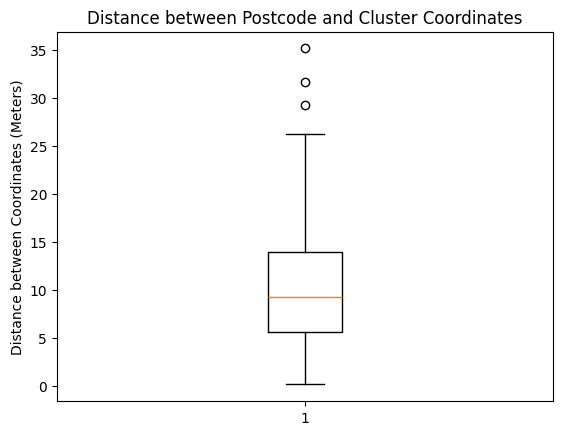

In [326]:
l = []

for i, row in final_set2.iterrows():
    coords_1 = (row['Latitude'], row['Longitude'])
    coords_2 = (row['Cluster Latitude'], row['Cluster Longitude'])
    result = geopy.distance.geodesic(coords_1, coords_2).m
    l.append(result)

plt.boxplot(l)
plt.ylabel('Distance between Coordinates (Meters)')
plt.title('Distance between Postcode and Cluster Coordinates')
plt.show()

#### We can see that the median distance between the two sets of coordinates is  9 meters and with the interqartile range being between 6 and 14 metres, we can assume that difference between the two sets of coordinates is negligable and can be ignored, thus we can continue this project using the estimated times calculated earlier on. We had ~ 60 rows with null values so we dropped them, these are just missing postcodes from the site from which we extracted the crime rate data 

#### 

# Visualising our plots using the plotly package 

## Let's start with looking at the house prices

In [332]:
fig3 = px.scatter_mapbox(final_set2.reset_index(),
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Postcode",                  
                        color="Average Price £000s",
                        height=600,
                        width=600)

fig3.update_layout(mapbox_style="open-street-map")
fig3.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig3.show()

### The above graph is difficult to see so instead we will change the map layout. You can zoom in to see points in detail 

## Average house prices

In [333]:
fig3 = px.scatter_mapbox(final_set2.reset_index(),
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Postcode",
                        color="Average Price £000s",
                        height=600,
                        width=600)

fig3.update_layout(mapbox_style="carto-positron")
fig3.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig3.show()

#### Starting with house prices Ilford and Romford seem to be on the lower side , with prices starting to increase in the areas past romford as well as towards Chigwell. Hackney, an area which was once run down, has also seen vast amounts of gentrification and subsequently higher house prices.

## Transit times in minutes

In [334]:
fig4 = px.scatter_mapbox(final_set2.reset_index(),
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Postcode",
                        color="Transit_time (Min)",
                        height=600,
                        width=600)

fig4.update_layout(mapbox_style="carto-positron")
fig4.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig4.show()

#### A large majority of people working in the city commute by train to work, therefore it is important to consider commuting time. Quiet obviously living around stratford will have the shortest commute time and moving out towards Loughton and past Romford towards upminister we can see the travel times can being noticeable longer. Compared to areas like ilford, the areas around Romford can be up to 15 minutes longer. Romford omly has one central station so this makes sense, and of course most towns have their stations in the centre and thus those properties nearer the center will have shorter commute times.

## Driving time in minutes

In [335]:
fig5 = px.scatter_mapbox(final_set2,
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Postcode",
                        color="Driving_time (Min)",
                        height=600,
                        width=600)

fig5.update_layout(mapbox_style="carto-positron")
fig5.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig5.show()


#### Given London's efficient road network, getting to Stratford seems to be proportional to the distace travelled, so if you're someone who would want to drive to the centre often living further out can be problematic. The Same principle applies to cycling as shown below.

## Cycling time in minutes

In [309]:
fig6 = px.scatter_mapbox(final_set2,
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Postcode",
                        color="Cycling Time (Min)",
                        height=600,
                        width=600)

fig6.update_layout(mapbox_style="carto-positron")
fig6.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig6.show()


#### Let us now look at Crime rates so we can try and narrow down areas to avoid.

## Violent crime per 1000 people

In [328]:
fig7 = px.scatter_mapbox(final_set2.reset_index(),
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Postcode",
                        color="Violent Crime rate per 1000",
                        height=800,
                        width=800)

fig7.update_layout(mapbox_style="carto-positron")
fig7.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig7.show()


#### Looking at the above graphs we can see that the violent of crime seems to be in the city centres, which is likely due to the large proportion of people passing through. On our map central Stratford appears to have the highest numbers of violent crimes, with walthamstow, central romford and barking also being on the higher end.

## 

In [331]:
fig7 = px.scatter_mapbox(final_set2.reset_index(),
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Postcode",
                        color="Antisocial Crime rate per 1000",
                        height=600,
                        width=600)

fig7.update_layout(mapbox_style="carto-positron")
fig7.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig7.show()


#### Antisocial behaviour seems to be more common is more areas, however is evidently more prominent in areas such as Whitechapel, Bethnal Green and Stratford, as well as Romford. It is at a moderate level in areas around Ilford, and low around Wanstead and Woodford.

## Burglary Crime rate

In [329]:
fig7 = px.scatter_mapbox(final_set2.reset_index(),
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Postcode",
                        color="Burglary Crime rate per 1000",
                        height=600,
                        width=600)

fig7.update_layout(mapbox_style="carto-positron")
fig7.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig7.show()


#### Burglary is somethng that can occuer in both run-down aswell as richer areas and is something that can be difficult to completely avoid. Similar to the previous graph The burglary rate is high in the areas around Stratford as well as those on the left of it such as Mile End and Bethnal Green. Other areas such as Wanstead and Walthomstow do have moderate rates of burglary with Harold wood being slightly higher. One thing to note is that these are crime rates per 1000 people so may not be as bad as they look. We would need the to compare them to other areas in the UK to consider what may be seen as a bad rate.

##### To conclude we can see that no area is perfect and all have their pros on cons. Starting with crime rate we can see that while stratford is ideal communicating wise it is high in all 3 of the different tpres of crime, luckily it is commutable to by other stations fairly easily due to it's vast rail network so while living there may not be ideal, this is not a worry if you use the train network. 

##### Mile end and Bethnal Green whilst being very close to Stratford and being affordably priced, have high levels of Antisocial Crime rate and Burglary so again may not be the most ideal areas to live in, so to shortlist, we can say we will avoid startford and areas on the west of it.

##### Driving and Cycling as we mentioned seems to be proportional to the distance from our station so we will focus our efforts more on Trainit(Public transport) and Average property prices.

##### As the objective was to be able was to get into london via Stratford, Transit times are one of the most important factors in this project. Most areas have a reasonable transit time besides those around or past Romford as well as those towards Chigwell and Loughton. Central Romford may have been a viable option due to the short commute and low average house prices, however due to the high crime rate this may not be possible, and as discussed for those areas around Romford, the transit time can become long. Although more dearer Wanstead seems to be one of the best places to live with low crime rates and short commuting time. Areas around such as Woodford and Fairlop also seem reasonable with average house prices and low crime rates.

#### The scope of this project could have been extended to the rest of London using similar clustering techniques, and could have given us a broader picture.


